In [1]:
# to work online. save weights of nn to google drive, e.t.c.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
# it is faster to use gpu or tpu
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print(device)

cuda


In [4]:
# !!!! for fast start without remaking cvs of lines and skip some next cells
corpus_name = "/content/drive/MyDrive/ChatBot/input/simpsons_dataset.csv"
#datafile is txt of formatted pairs 
datafile = "/content/drive/MyDrive/ChatBot/input/formatted_simpsons_movie_lines.txt"

In [ ]:
# make this path to csv file with your corpus 
corpus_name = "/content/drive/MyDrive/ChatBot/input/simpsons_dataset.csv"

In [5]:
# making sure it works 
def printLines(file, n=10):
    with open(file, 'rb') as datafile:
        lines = datafile.readlines()
    for line in lines[:n]:
        print(line)

printLines(corpus_name)

b'raw_character_text,spoken_words\r\n'
b'Miss Hoover,"No, actually, it was a little of both. Sometimes when a disease is in all the magazines and all the news shows, it\'s only natural that you think you have it."\r\n'
b"Lisa Simpson,Where's Mr. Bergstrom?\r\n"
b"Miss Hoover,I don't know. Although I'd sure like to talk to him. He didn't touch my lesson plan. What did he teach you?\r\n"
b'Lisa Simpson,That life is worth living.\r\n'
b'Edna Krabappel-Flanders,"The polls will be open from now until the end of recess. Now, just in case any of you have decided to put any thought into this, we\'ll have our final statements. Martin?"\r\n'
b"Martin Prince,I don't think there's anything left to say.\r\n"
b'Edna Krabappel-Flanders,Bart?\r\n'
b'Bart Simpson,Victory party under the slide!\r\n'
b',\r\n'


Орабатывая входную последовательность, мы хотим обобщить всю информацию, которая в ней содержится в некий вектор С
Далее мы передаем этот вектор во вторую RNN, которая является декодером
https://habr.com/ru/company/wunderfund/blog/331310/

Пример заранее определнной функции для очистки естественного языка

https://www.kaggle.com/code/currie32/a-south-park-chatbot
```
def clean_text(text):
    '''Clean text by removing unnecessary characters and altering the format of words.'''

    text = text.lower()
    
    text = re.sub(r"\n", "",  text)
    text = re.sub(r"[-()]", "", text)
    text = re.sub(r"\.", " .", text)
    text = re.sub(r"\!", " !", text)
    text = re.sub(r"\?", " ?", text)
    text = re.sub(r"\,", " ,", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"ohh", "oh", text)
    text = re.sub(r"ohhh", "oh", text)
    text = re.sub(r"ohhhh", "oh", text)
    text = re.sub(r"ohhhhh", "oh", text)
    text = re.sub(r"ohhhhhh", "oh", text)
    text = re.sub(r"ahh", "ah", text)
    
    return text
```



In [6]:
# Extracts pairs of sentences from conversations
# makes pairs of (input, answer)
# Remember to comment here debug if you want the entire corpus
def extractSimpsonsSentencePairs(fileName):
    qa_pairs = []
    
    with open(fileName, 'r', encoding='utf-8') as f:
        lines = f.read().strip().split('\n')
        
        for i in range(1, len(lines) - 1):
            # if (i > 5000): break # debug
            inputLine = lines[i].split(',', 1)[1].strip(',.""')
            if lines[i+1]==',':
                continue #start next scene
            targetLine = lines[i+1].split(',', 1)[1].strip(',.""')
            
            if (len(inputLine) > 0 and len(targetLine) > 0):
                qa_pairs.append([inputLine, targetLine])
    
    return qa_pairs

In [7]:
# Define path to new file
#datafile = os.path.join(corpus, "formatted_movie_lines.txt")
datafile = "/content/drive/MyDrive/ChatBot/input/formatted_simpsons_movie_lines.txt"

delimiter = '\t'
# Unescape the delimiter
delimiter = str(codecs.decode(delimiter, "unicode_escape"))

In [ ]:

# Write new csv file
print("\nWriting newly formatted file...")
with open(datafile, 'w', encoding='utf-8') as outputfile:
    writer = csv.writer(outputfile, delimiter=delimiter, lineterminator='\n')    
    for pair in extractSimpsonsSentencePairs(corpus_name):
        writer.writerow(pair)
        
        

# Print a sample of lines
print("\nSample lines from file:")
printLines(datafile)


Writing newly formatted file...

Sample lines from file:
b"No, actually, it was a little of both. Sometimes when a disease is in all the magazines and all the news shows, it's only natural that you think you have it\tWhere's Mr. Bergstrom?\n"
b"Where's Mr. Bergstrom?\tI don't know. Although I'd sure like to talk to him. He didn't touch my lesson plan. What did he teach you?\n"
b"I don't know. Although I'd sure like to talk to him. He didn't touch my lesson plan. What did he teach you?\tThat life is worth living\n"
b"That life is worth living\tThe polls will be open from now until the end of recess. Now, just in case any of you have decided to put any thought into this, we'll have our final statements. Martin?\n"
b"The polls will be open from now until the end of recess. Now, just in case any of you have decided to put any thought into this, we'll have our final statements. Martin?\tI don't think there's anything left to say\n"
b"I don't think there's anything left to say\tBart?\n"
b'B

In [5]:
# Default word tokens, i.e. not words, but special markers to indicate:
PAD_token = 0  # Used for padding short sentences to max lenght
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

# class vocabulary 
# stores words with indexes to identify, i.e. makes tokenezation possible

class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD
    
#     adds each word in sentence
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
# add word if its not exist, or count++ else
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

# Remove words below a certain count threshold
#     stores what good, remakes voc with only those 
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens

        for word in keep_words:
            self.addWord(word)

In [6]:
MAX_LENGTH = 15  # Maximum sentence length in runes to consider 

# Turn a Unicode string to plain ASCII  https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"i'm", "i am", s)
    s = re.sub(r"\'s", " is", s)
    s = re.sub(r"he's", "he is", s) #redunant 
    s = re.sub(r"she's", "she is", s)
    s = re.sub(r"it's", "it is", s)
    s = re.sub(r"that's", "that is", s)
    s = re.sub(r"what's", "that is", s)
    s = re.sub(r"\'ve", " have", s)
    s = re.sub(r"\'ll", " will", s)
    s = re.sub(r"\'re", " are", s)
    s = re.sub(r"won't", "will not", s)
    s = re.sub(r"can't", "cannot", s)
    s = re.sub(r"n't", " not", s)
    s = re.sub(r"\'d", " would", s)
    s = re.sub(r"\.+","\.",s)
    s = re.sub(r"([.!?])", r" \1", s) # add space before .?!
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s) # replace other nonletter(includes ,)
    s = re.sub(r"\s+", r" ", s).strip()  # replace whitespaces with  only one
    return s

# Read query/response pairs and return a voc object
def readVocs(datafile, corpus_name):
    print("Reading lines...")
    # Read the file and split into lines
    lines = open(datafile, encoding='utf-8').\
        read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    voc = Voc(corpus_name)
    return voc, pairs

# Returns True if both sentences in a pair 'p' are under the MAX_LENGTH threshold
def filterPair(p):
    # Input sequences need to preserve the last word for EOS token
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

# Filter pairs using filterPair condition
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# Using the functions defined above, return a populated voc object and pairs list
# datafile stores pairs
def loadPrepareData( corpus_name, datafile, save_dir):
    print("Start preparing training data ...")
    voc, pairs = readVocs(datafile, corpus_name)
    print("Read {!s} sentence pairs".format(len(pairs)))
    pairs = filterPairs(pairs)
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Counted words:", voc.num_words)
    return voc, pairs

In [7]:
# Load/Assemble voc and pairs
save_dir = os.path.join("data", "save")
voc, pairs = loadPrepareData( corpus_name, datafile, save_dir) #corpus name stands only for file name
# Print some pairs to validate
print("\npairs:")
for pair in pairs[:10]:
    print(pair)

Start preparing training data ...
Reading lines...
Read 110373 sentence pairs
Trimmed to 59470 sentence pairs
Counting words...
Counted words: 24372

pairs:
['i do not think there is anything left to say', 'bart ?']
['bart ?', 'victory party under the slide !']
['do you know where i could find him ?', 'i think he is taking the next train to capital city']
['i think he is taking the next train to capital city', 'the train how like him . traditional yet environmentally sound']
['hey thanks for your vote man', 'i did not vote . voting is for geeks']
['i did not vote . voting is for geeks', 'well you got that right . thanks for your vote girls']
['well you got that right . thanks for your vote girls', 'we forgot']
['uh oh', 'lewis ?']
['lewis ?', 'somebody must have voted']
['somebody must have voted', 'what about you bart ? did not you vote ?']


In [ ]:
# dir to save data, including weights 
save_dir


'data/save'

In [8]:
MIN_COUNT = 3    # Minimum word count threshold for trimming

def trimRareWords(voc, pairs, MIN_COUNT):
    # Trim words used under the MIN_COUNT from the voc
    voc.trim(MIN_COUNT)
    # Filter out pairs with trimmed words
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # Check input sentence
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break
        # Check output sentence
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break

        # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs

In [9]:
# Trim voc and pairs
pairs = trimRareWords(voc, pairs, MIN_COUNT)

keep_words 11707 / 24369 = 0.4804
Trimmed from 59470 pairs to 45381, 0.7631 of total


In [10]:
# functions to encode sentence
# want to make a matrix to pass in autoencoder 

def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]


def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))
# Функция zip_longest() модуля itertools создает итератор, который объединяет элементы из каждой итерируемой последовательности
# *iterables в кортежи. работает пока самая длинная итерация не будет исчерпана, а пропущенные элементы заполняются значением fillvalue.
# https://docs-python.ru/standart-library/modul-itertools-python/funktsija-zip-longest-modulja-itertools/

# makes one-hot encoding 
def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# Returns padded input sequence tensor and lengths
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths


# Mask indicates if a value zero (PAD_token) or a actual data 
# Returns padded target sequence tensor, padding mask, and max target length
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.BoolTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# Returns all items for a given batch of pairs
def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len

In [11]:
# !Example for validation
# to verify output 
small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

print("input_variable:", input_variable)
print("lengths:", lengths)
print("target_variable:", target_variable)
print("mask:", mask)
print("max_target_len:", max_target_len)

input_variable: tensor([[ 378,  152,  123,  345,   50],
        [ 162,   50,  164,   35,  143],
        [ 150,  136,   35,  797,  302],
        [6477,  176,   65, 1980, 4798],
        [ 436,  834, 2488,   20,    2],
        [  97,  111, 7604,    2,    0],
        [1054,  103,    2,    0,    0],
        [  11,    2,    0,    0,    0],
        [ 240,    0,    0,    0,    0],
        [ 122,    0,    0,    0,    0],
        [ 129,    0,    0,    0,    0],
        [ 173,    0,    0,    0,    0],
        [   2,    0,    0,    0,    0]])
lengths: tensor([13,  8,  7,  6,  5])
target_variable: tensor([[ 260,  131, 7814,   93, 1915],
        [   3,   27,    2,   21,  150],
        [ 143, 4637,    0,   89, 1121],
        [  92,   65,    0, 2473,   35],
        [  14,  909,    0,  220,  159],
        [   2,  162,    0, 1599,   35],
        [   0,  627,    0,  198,  531],
        [   0,  243,    0,   14,   20],
        [   0, 1130,    0,    2,    2],
        [   0,   53,    0,    0,    0],
        

In [12]:
# encoder for gru. main flow of data. Bidirectional
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
#         https://pytorch.org/docs/stable/generated/torch.nn.GRU.html
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden

In [13]:
# Luong attention layer, linear 
# i.e. attention encoder, aside flow of data
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
#        Luong attention mechanism have 3 different ways
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)
#     dim (int or tuple of python:ints) – the dimension or dimensions to reduce.

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

In [2]:
# attention decoder, params - n_layers, dropuot 
#  decoder of aside data flow, GRU
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden

NameError: name 'nn' is not defined

In [15]:
# it is reasonable to check loss only on data, but not comparing with PAD
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    # https://stackoverflow.com/questions/50999977/what-does-the-gather-function-do-in-pytorch-in-layman-terms
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    # item - makes int from 0d tensor
    return loss, nTotal.item()

In [16]:
# main train function 
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH):

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)
    # Lengths for rnn packing should always be on the cpu
    lengths = lengths.to("cpu")

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
#             Returns the k largest elements of the given input tensor along a given dimension.
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    # Perform backpropatation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

In [17]:
# makes training start from custom load 
# https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html

def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, clip, corpus_name, loadFilename):

    # Load batches for each iteration
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    loss_plot = []
    iter_plot = []
    # Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # Run a training iteration with batch
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_loss += loss

        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg), end='\n')
            print_loss = 0
            iter_plot.append(iteration)
            loss_plot.append(print_loss_avg)

        # Save checkpoint
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, model_name,corpus_name, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))
    return loss_plot, iter_plot

In [18]:
# makes model eval in  real time
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)

        # actually can try without that 
        all_scores = torch.zeros([0], device=device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores

In [19]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to("cpu")
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            # Get input sentence
            input_sentence = input('you> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            # Normalize sentence
            input_sentence = normalizeString(input_sentence)
            # Evaluate sentence
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            # Format and print response sentence
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Bot>', ' '.join(output_words))

        except KeyError:
            print("Error: Encountered unknown word.")

In [58]:
# Configure models
model_name = 'cb_model'
attn_model = 'dot' #or could be concat and general - see LuongEncoder for more details 
hidden_size = 750
encoder_n_layers = 3
decoder_n_layers = 2
dropout = 0.1
batch_size = 64


# Configure training/optimization
clip = 10.0
learning_rate = 0.0001
decoder_learning_ratio = 10.0
n_iteration = 12000
print_every = 250
save_every = 12000



# Set checkpoint to load from; set to None if starting from scratch
loadFilename = None
checkpoint_iter = 4000
loadFilename = os.path.join(save_dir, model_name, corpus_name.strip('.csv'),
                           '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
                           '{}_checkpoint.tar'.format(checkpoint_iter))


# Load model if a loadFilename is provided
if loadFilename:
    # If loading on same machine the model was trained on
    checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']


print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)
# Initialize encoder & decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')

Building encoder and decoder ...
Models built and ready to go!


In [ ]:

teacher_forcing_ratio = 0.9

# Ensure dropout layers are in train mode
encoder.train()
decoder.train()

# Initialize optimizers
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
if loadFilename:
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)

# If you have cuda, configure cuda to call
for state in encoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

for state in decoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()
# , teacher_forcing_ratio  out of scoup 
# Run training iterations
print("Starting Training!")
loss_plot, iter_plot = trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name.strip('.csv'), loadFilename)

Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 4250; Percent complete: 35.4%; Average loss: 3.2745
Iteration: 4500; Percent complete: 37.5%; Average loss: 3.1798
Iteration: 4750; Percent complete: 39.6%; Average loss: 3.0966
Iteration: 5000; Percent complete: 41.7%; Average loss: 3.0308
Iteration: 5250; Percent complete: 43.8%; Average loss: 3.0092
Iteration: 5500; Percent complete: 45.8%; Average loss: 2.8724
Iteration: 5750; Percent complete: 47.9%; Average loss: 2.7074
Iteration: 6000; Percent complete: 50.0%; Average loss: 2.7107
Iteration: 6250; Percent complete: 52.1%; Average loss: 2.7485
Iteration: 6500; Percent complete: 54.2%; Average loss: 2.6478
Iteration: 6750; Percent complete: 56.2%; Average loss: 2.6507
Iteration: 7000; Percent complete: 58.3%; Average loss: 2.5473
Iteration: 7250; Percent complete: 60.4%; Average loss: 2.4009
Iteration: 7500; Percent complete: 62.5%; Average loss: 2.4131
Iteration: 7750; Percent complete: 64.6%; Aver

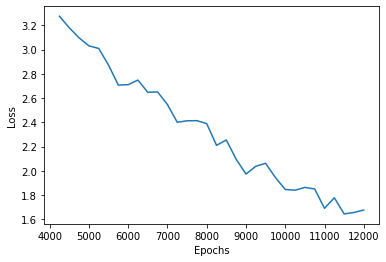

In [60]:
plt.plot(iter_plot, loss_plot)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

loss NAN

```
clip = 1.0
learning_rate = 0.01
decoder_learning_ratio = 5.0
n_iteration = 400
print_every = 25
save_every = 100

```



In [62]:
# Set dropout layers to eval mode
encoder.eval()
decoder.eval()

# Initialize search module
searcher = GreedySearchDecoder(encoder, decoder)

Be cearful what you wish for, son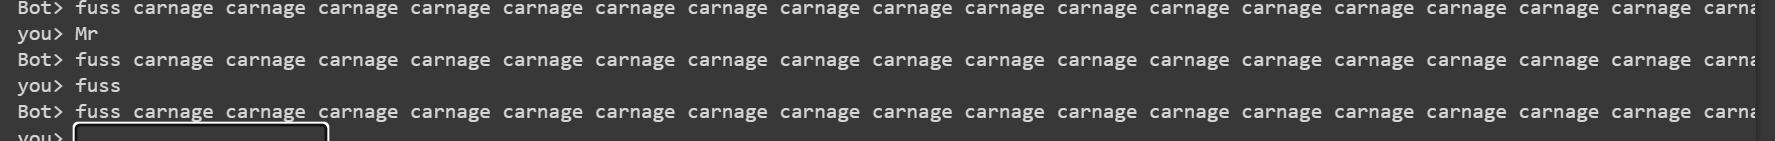

In [63]:
# Begin chatting (uncomment and run the following line to begin)
evaluateInput(encoder, decoder, searcher, voc)

you> Hello! 
Bot> now i am really really now
you> What do you think ? 
Bot> who is chester ? used used
you> Do you like me ?
Bot> no you me you me you you you
you> How are you ?
Bot> well i am . i am not very but i am better school
you> Did you vote ?
Bot> oh i do not know
you> I want to be your friend
Bot> marge i will be late can ?
you> Good weather
Bot> what if i can burn your your job back ?
you> Can you mind yourself ?
Bot> oh oh i know know
you> Homer ?
Bot> what ?
you> Am i annoying ?
Bot> it is too
you> i knew it
Bot> why you say dad . how is the best dad always says ?
you> i love you, dad
Bot> i love to i have to love how i
you> q


Список некоторых используемых источников 
https://pytorch.org/tutorials/beginner/chatbot_tutorial.html
https://www.kaggle.com/datasets/pierremegret/dialogue-lines-of-the-simpsons
https://www.ijitee.org/wp-content/uploads/papers/v8i10/J88670881019.pdf
https://www.ijsmdo.org/articles/smdo/full_html/2020/01/smdo190024/smdo190024.html
https://towardsdatascience.com/generative-chatbots-using-the-seq2seq-model-d411c8738ab5
https://bhashkarkunal.medium.com/conversational-ai-chatbot-using-deep-learning-how-bi-directional-lstm-machine-reading-38dc5cf5a5a3, прошлая версия работы https://www.kaggle.com/code/ferbor/d7046e-chatbot-experiment-simpsons-version